In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.graph_models import TreeNode, Order, Family, graph, pickNode
from traversals.strategies import sumTrees, UniformRandomSampleForest

In this notebook I´ll create functions for easing the development of geostatistical models using the GPFlow (James H, et.al )the library for modelling gaussian processes in Tensor Flow (Google) (Great Library, btw).

## Requirements

### Inputs
* Design Matrix X composed of coovariates and spatio-temporal coordinates.
* A desired hypespace $A \subseteq \mathbb{R}^{n}$ (e.g. Borelian, Closed, Discrete,Partition)
* An aditional set of hyperparameters and initializations.

### Processing
* A wrapper with GPflow regressor (This will be experimental)

### Outputs
* The fitted GPR model.
* A tensor composed of the coordinates of two dimensions and the predicted field given a initial condition (tensor of rank two.



# Get some sample data


In [4]:
run ../../../../traversals/tests.py

DEBUG Changed MESH TABLE SPACE
INFO Getting information. DEveloper! You can make this faster if you use Batchmode for py2neo.
INFO Retrieving the Tree Structures. 
 Get a coffee this will take time.
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
INFO Merging Trees
DEBUG Changed MESH TABLE SPACE


# GPFlow first approximation

In [12]:
import tensorflow as tf
import GPflow as gf
import pandas as pd
#k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [3,4])
X = pd.concat((rd[['MeanTemperature_mean','Precipitation_mean','WindSpeed_mean']],s[['Longitude','Latitude']]),axis=1)
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1])
X = s[['Longitude','Latitude']]
Y = rd['Elevation_mean']



In [41]:
mx = X.as_matrix()
my = Y.as_matrix().reshape(16,1)
mx.shape
meanf = gf.mean_functions.Linear(np.ones((2,1)), np.ones(1))
m = gf.gpr.GPR(mx,my,k,mean_function=meanf)
m.optimize()
m.likelihood.variance = 10
print(m)

name.kern.lengthscales transform:+ve prior:None
[ 0.03719554]
name.kern.variance transform:+ve prior:None
[ 10830.59025205]
name.likelihood.variance transform:+ve prior:None
[ 10.]
name.mean_function.A transform:(none) prior:None
[[-22.33709169]
 [  5.16483343]]
name.mean_function.b transform:(none) prior:None
[ 1.25283016]


## Buidling a grid for the interpolation (prediction)
The first step is to inspect the range of the geographical space.


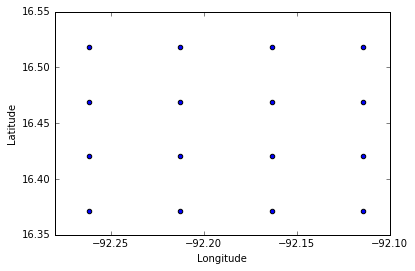

In [42]:
X.plot.scatter('Longitude','Latitude')

### Lets build a mesh grid and then a pcolor using that meshgrid.

In [95]:
Nn = 300
predicted_x = np.linspace(min(X.Longitude),max(X.Longitude),Nn)
predicted_y = np.linspace(min(X.Latitude),max(X.Latitude),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
predicted_coordinates = np.vstack([Xx.ravel(), Yy.ravel()]).transpose()

In [96]:
predicted_coordinates.shape

(90000, 2)

In [97]:
means,variances = m.predict_y(predicted_coordinates)

In [107]:
plt.style.use('ggplot')

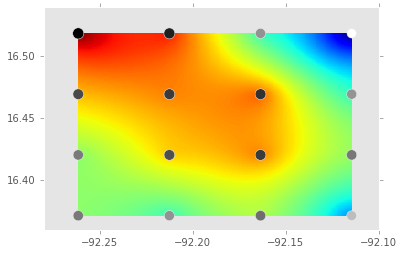

In [117]:
### Let´s plot
#X.plot.scatter('Longitude','Latitude')
plt.pcolor(Xx,Yy,means.reshape(Nn,Nn))
plt.scatter(X.Longitude,X.Latitude,s=Y*0.05,c=Y,cmap=plt.cm.binary)




## We can get the direct Elevation data with:

In [118]:
elev = big_t.associatedData.getAssociatedRasterAreaData('Elevation')

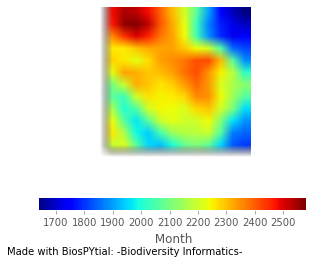

(13, 13)


In [151]:
elev.display_field()
print(elev.rasterdata.bands[0].data().shape)

In [120]:
## But we can extract directly the info from this raster.
from django.contrib.gis.geos import Point
true_elevs = map(lambda p : elev.getValue(Point(*p)),predicted_coordinates)

In [121]:
# so the errors are: 
errors= means - true_elevs

(array([   15.,    31.,    49.,    72.,   125.,   180.,   225.,   250.,
          277.,   285.,   255.,   233.,   225.,   227.,   289.,   354.,
          576.,   979.,  1315.,  1789.,  2233.,  2832.,  3576.,  3865.,
         3653.,  4631.,  4582.,  4734.,  6050.,  5691.,  5667.,  5166.,
         4997.,  4363.,  2609.,  1750.,  1839.,  2083.,  1821.,  1238.,
         1316.,  1114.,   906.,  1311.,  1622.,   506.,   773.,   957.,
          338.,    26.]),
 array([-339.51473116, -328.92879389, -318.34285661, -307.75691934,
        -297.17098206, -286.58504479, -275.99910752, -265.41317024,
        -254.82723297, -244.24129569, -233.65535842, -223.06942114,
        -212.48348387, -201.89754659, -191.31160932, -180.72567204,
        -170.13973477, -159.55379749, -148.96786022, -138.38192294,
        -127.79598567, -117.21004839, -106.62411112,  -96.03817384,
         -85.45223657,  -74.86629929,  -64.28036202,  -53.69442474,
         -43.10848747,  -32.52255019,  -21.93661292,  -11.35067564

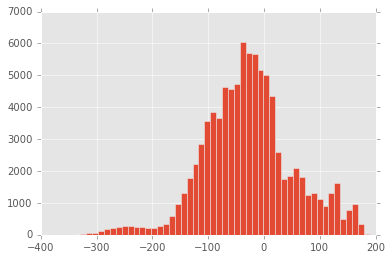

In [148]:
plt.hist(errors,bins=50)

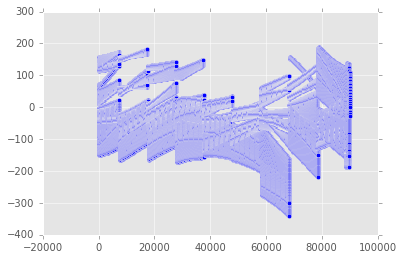

In [152]:
plt.scatter(range(len(errors)),errors)

# Using all* covariates for predicting elevation

In [153]:
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [6,7])
X = pd.concat((rd[['MaxTemperature_mean', u'MeanTemperature_mean',
       u'MinTemperature_mean', u'Precipitation_mean', u'SolarRadiation_mean',
       u'Vapor_mean']],s[['Longitude','Latitude']]),axis=1)
mx = X.as_matrix()
#Y is still elevation (4,4) matrix
my = Y.as_matrix().reshape(16,1)
meanf = gf.mean_functions.Linear(np.ones((8,1)), np.ones(1))
m = gf.gpr.GPR(mx,my,k,mean_function=meanf)
m.likelihood.variance = 10
m.optimize()
print(m)


name.kern.lengthscales transform:+ve prior:None
[ 0.99577864]
name.kern.variance transform:+ve prior:None
[ 1.11218849]
name.likelihood.variance transform:+ve prior:None
[ 10.09839655]
name.mean_function.A transform:(none) prior:None
[[-0.06323548]
 [-0.06116383]
 [-0.07247325]
 [-0.01247727]
 [ 0.00300557]
 [ 0.86165553]
 [ 0.72914064]
 [ 1.05763773]]
name.mean_function.b transform:(none) prior:None
[ 1.00267777]


In [134]:
X.columns

Index([u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'Longitude', u'Latitude'],
      dtype='object')

In [137]:
mx = X.as_matrix()
my = Y.as_matrix().reshape(16,1)
mx.shape
meanf = gf.mean_functions.Linear(np.ones((8,1)), np.ones(1))
m = gf.gpr.GPR(mx,my,k,mean_function=meanf)
m.likelihood.variance = 10
m.optimize()
print(m)

name.kern.lengthscales transform:+ve prior:None
[  1.00000000e-06]
name.kern.variance transform:+ve prior:None
[ 267.33309527]
name.likelihood.variance transform:+ve prior:None
[ 29.46782876]
name.mean_function.A transform:(none) prior:None
[[-54.35239548]
 [-55.9060937 ]
 [-54.67952473]
 [ -9.09155351]
 [  0.27752281]
 [ -6.00440268]
 [-14.89900903]
 [  4.73777599]]
name.mean_function.b transform:(none) prior:None
[ 1.15924765]


In [85]:
# Now Let´s do a Logistic Regression

-92.114563415999996

In [138]:
s

,Falconidae,Longitude,Latitude
0,0.0,-92.261563,16.51839
1,0.0,-92.212563,16.51839
2,0.0,-92.163563,16.51839
3,0.0,-92.114563,16.51839
4,0.0,-92.261563,16.46939
5,1.0,-92.212563,16.46939
6,0.0,-92.163563,16.46939
7,1.0,-92.114563,16.46939
8,1.0,-92.261563,16.42039
9,0.0,-92.212563,16.42039


In [144]:
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1])
X = s[['Longitude','Latitude']]
Y = s[['Falconidae']]
mx = X.as_matrix()
my = Y.as_matrix().reshape(16,1)
meanf = gf.mean_functions.Linear(np.ones((2,1)), np.ones(1))
## I need a likelihood function !
m = gf.gpmc.GPMC(mx,my,k,mean_function=meanf)
#m.likelihood.variance = 10
m.optimize()
#print(m)

TypeError: __init__() takes at least 5 arguments (5 given)

## Future path and questions
1. GLM (Bernoulli for predicting species presences $Y_{i,s}$)
2. Markov-Fields and GPR differences (Global vs Contextual)?
    Need to explore this.
3. Expand kernel to cover temporal using the bands in Bioclim covariates.
    Proposal: Partionate the 12 bands along a Julian Day index.
4. Explore using DEM-derived data (e.g Slope, Aspect, etc)
5. Some light in the GLM-GP. I have problems with the likelihood and I think it´s not as easy to solve as:
$$h^{-1}(E(S|X*))$$